In [1]:
%load_ext iminizinc

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets
from ipywidgets import *
from IPython.display import display
import IPython
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

from datetime import datetime
# import talib
import pandas_ta as ta
# from talib.abstract import *
from math import *
from collections import OrderedDict
# import vectorbt as vbt    
import json
from decimal import *
getcontext().prec = 6
# import seaborn as sns

# import mplfinance as mpf
%matplotlib inline

mpl.rcParams.update({'font.size': 5, 'lines.linewidth': 0.5, 'figure.dpi': 300})
plt.rcParams['lines.linewidth'] = 0.5 



<IPython.core.display.Javascript object>

MiniZinc to FlatZinc converter, version 2.7.4, build 863757726
Copyright (C) 2014-2023 Monash University, NICTA, Data61


In [2]:
odf = pd.read_json(r'../freq-user-data/data/binance/BTC_USDT-4h.json').dropna()
odf.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']

odf['date'] = pd.to_datetime(odf['timestamp'], unit='ms', utc=False)
odf['idate'] = odf.date.dt.strftime('%Y%m%d')
odf.set_index(pd.DatetimeIndex(odf["date"]), inplace=True, drop=True)
odf = odf.sort_index()
odf

,timestamp,open,high,low,close,volume,date,idate
date,,,,,,,,
2021-01-01 00:00:00,1609459200000,28923.63,29470.00,28690.17,29278.40,11560.456553,2021-01-01 00:00:00,20210101
2021-01-01 04:00:00,1609473600000,29278.41,29395.00,28806.54,29092.83,7308.910274,2021-01-01 04:00:00,20210101
2021-01-01 08:00:00,1609488000000,29092.84,29402.57,28872.24,29313.49,8283.705319,2021-01-01 08:00:00,20210101
2021-01-01 12:00:00,1609502400000,29313.49,29600.00,29030.14,29188.67,11794.949515,2021-01-01 12:00:00,20210101
2021-01-01 16:00:00,1609516800000,29188.67,29360.00,28624.57,29029.04,9850.965345,2021-01-01 16:00:00,20210101
...,...,...,...,...,...,...,...,...
2023-05-12 00:00:00,1683849600000,26968.61,27091.12,26528.01,26584.32,9615.458560,2023-05-12 00:00:00,20230512
2023-05-12 04:00:00,1683864000000,26584.33,26710.00,26120.74,26311.52,15964.270710,2023-05-12 04:00:00,20230512
2023-05-12 08:00:00,1683878400000,26311.51,26437.00,26234.79,26348.01,6428.017950,2023-05-12 08:00:00,20230512


In [ ]:
layout1 = cf.Layout(
    height=300,
    width=200
)
# print(matplotlib.pyplot.gcf())

fig = odf.figure()
# data=odf.figure()['data']


qf=cf.QuantFig(odf,title='Quant Figure',legend='top',name='GS' )
# qf.figure().axhline(20000)
qf.iplot(dimensions =(1500,500))

fig.add_hline(y=51000)
fig



## Last Swing Low -> Swing High 

In [138]:
df = odf['2023-02-01':]

kl_n = len(df)
kl_close = df.close.astype(int).tolist()
kl_idate = df.idate.to_list()
inow = df.shape[0] 
model_params = {'kl_n': kl_n, 'kl_close': kl_close, 'kl_idate': kl_idate, 'inow': inow}
with open('swing_high.json', 'w+') as f:
    f.write(json.dumps(model_params, indent=0))
    # f.write(f'kl_n = {len(df)};\n')
    # f.write(f'kl_signal = [' + ', '.join(df.close.astype(int).astype(str)) + '];\n')
# kl_idate

In [161]:
from minizinc import Instance, Model, Solver
import nest_asyncio
nest_asyncio.apply()

swing_high = Model("./swing_high.mzn")
# Find the MiniZinc solver configuration for Gecode
gecode = Solver.lookup("gecode")
# Create an Instance of the n-Queens model for Gecode
instance = Instance(gecode, swing_high)

for k,v in model_params.items(): instance[k] = v
    # print(k,v)
# instance["n"] = 4
result = instance.solve()
# # Output the array q
print(result)

Solution(objective=232, ipeak_0=217, ipeak_1=70, itrough_0=115, obj=232, _checker='')


In [120]:
%%minizinc -m bind

array[int] of int: kl_close;

int: kl_n;
set of int: KLN = 1..kl_n;
int: inow;
var int: ipeak_0;
var int: ipeak_1;
var int: itrough_0;

array[1..4] of var int: apktr = [ipeak_1, itrough_0, ipeak_0, inow];

constraint forall(k in apktr) (k >= 1 /\ k <= kl_n);
constraint forall(i in 1..3)(apktr[i+1] - apktr[i] > 3 * 7 * 2);
include "increasing.mzn";
constraint increasing([ipeak_1, itrough_0, ipeak_0]);
include "all_different.mzn";
constraint all_different([ipeak_1, itrough_0, ipeak_0]);
constraint forall(i in itrough_0..ipeak_0)(kl_close[i] >= kl_close[itrough_0] /\ kl_close[i] <= kl_close[ipeak_0]);
constraint forall(i in ipeak_1..itrough_0)(kl_close[i] >= kl_close[itrough_0] /\ kl_close[i] <= kl_close[ipeak_1]);
constraint forall(i in ipeak_0..inow)(kl_close[i] <= kl_close[ipeak_0]);
constraint kl_close[ipeak_0] >= kl_close[ipeak_1];

var int: obj;
constraint obj = inow - ipeak_1;


solve minimize obj;

In [85]:
import mplfinance as fplt
from minizinc import Instance, Model, Solver
import nest_asyncio
nest_asyncio.apply()

fibs = [0, 0.236, 0.382, 0.5, 0.618, 0.786, 1]

dlen = len(odf)

kl_n, kl_close, kl_idate, inow = None,None,None,None
ipeak_1, itrough_0, ipeak_0 = None, None, None
wdf = None

# sl_start= IntSlider(description="Str", min=0, max=dlen, step=10, value=dlen-200)
# sl_end = IntSlider(description="End", min=0, max=dlen, value=dlen, step=10)
sl_range = IntRangeSlider(
    value=[int(dlen-1000), dlen],
    min=0,
    max=dlen,
    step=50,
    description='Rng',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)
sl_now = IntSlider(description="Now", min=0, max=dlen, value=dlen, step=50)

# def change_end(val):
#     sl_start.value = sl_end.value - 700
#     sl_end.observe(change_end, 'value')

def range_changed(v):
    wstart, wend = sl_range.value
    sl_now.max = wend-wstart
    # print('Calc wdf.shape: ', wdf.shape)


sl_range.observe(range_changed, 'value')

ui = widgets.VBox([VBox([sl_range, sl_now])])
# wstart, wend
def printer(wrange, inow):
    global kl_n, kl_close, kl_idate
    global ipeak_1, itrough_0, ipeak_0
    global wdf

    wstart, wend = sl_range.value
    wdf = odf.iloc[wstart:wend, :]
    print('inow=',inow)
    if wdf is None: return
    # wdf = odf.iloc[wstart:wend, :]

    kl_n = wdf.shape[0]
    kl_close = wdf.close.astype(int).tolist()
    kl_idate = wdf.idate.to_list()
    
    model_params = {'kl_n': kl_n, 'inow': inow, 'kl_close': kl_close}
    with open('swing_high.json', 'w+') as f: f.write(json.dumps(model_params, indent=0))

    # print('Model params:', model_params)
    swing_high = Model("./swing_high.mzn")
    gecode = Solver.lookup("gecode")
    instance = Instance(gecode, swing_high)

    # instance.branch()
    for k,v in model_params.items(): instance[k] = v
    result = instance.solve()

    print(result)
    i_1, i_2, i_3, obj = resarr = [result['i_1'],result['i_2'],result['i_3'],result['obj']]

    swing_low, swing_high = kl_close[i_2-1], kl_close[i_3-1]
    fib_levels = [swing_low + f*(swing_high-swing_low) for f in fibs]
    # %minizinc swing_high kl_n=kl_n
    
    s = mpf.make_mpf_style(base_mpf_style='charles', rc={'font.size': 8})
    fig = mpf.figure(figsize=(15, 4), style=s) # pass in the self defined style to the whole canvas
    ax = fig.add_subplot(1,1,1) # main candle stick chart subplot, you can also pass in the self defined style here only for this subplot
    # av = fig.add_subplot(2,1,2, sharex=ax)  # volume chart subplot
    # wdf.close.plot(ax=ax, lw=1)

    ################################
    # ax.plot(wdf.close, lw=1)
    # ax.axvline(wdf.index[inow-1], c='b', lw=0.7)
    # ax.axvline(wdf.index[i_1-1], c='g', lw=0.7)
    # ax.axvline(wdf.index[i_3-1], c='g', lw=0.7)
    # ax.axvline(wdf.index[i_2-1], c='r', lw=0.7)
    # ax.hlines(fib_levels, wdf.index[i_2-1], wdf.index[inow-1], lw=0.5)

    ################################
    # for f in fibs:
    #     l = swing_low + f*(swing_high-swing_low)
        

    # for v in [ipeak_0, ipeak_1, itrough_0]: ax.axvline(v-1, lw=0.7)
    ####################
    mpf.plot(wdf, type='candle', ax=ax)
    ax.axvline(inow-1, c='b', lw=0.7)
    # ax.axvline(i_1-1, c='g', lw=0.7)
    ax.axvline(i_3-1, c='g', lw=0.7)
    ax.axvline(i_2-1, c='r', lw=0.7)
    ax.hlines(fib_levels, i_2-1, inow-1, lw=0.5)

out = widgets.interactive_output(printer, {'wrange': sl_range, 'inow': sl_now})
display(ui, out)


Output()

### FInd all swing-low-->swing-highs and fib levels

In [84]:
from minizinc import Instance, Model, Solver
import nest_asyncio
nest_asyncio.apply()
%matplotlib inline
# %matplotlib

strategy = 'all-swing_highs'
strategy_params_json = f'./strategy-params/{strategy}.json'

fibs = [0, 0.236, 0.382, 0.5, 0.618, 0.786, 1]

dlen = len(odf)

kl_n, kl_close, kl_idate, inow = None,None,None,None
idxs = None
wdf = None

sl_range = IntRangeSlider(
    value=[int(dlen-1000), dlen],
    min=0,
    max=dlen,
    step=100,
    description='Rng',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)
# sl_now = IntSlider(description="Now", min=0, max=dlen, value=dlen, step=50)

# def range_changed(v):
#     wstart, wend = sl_range.value
#     sl_now.max = wend-wstart

# sl_range.observe(range_changed, 'value')
strategy_params = {}
strategy_params = {"wrange": {'wdg': sl_range}, **strategy_params}
wdgts = [pv['wdg'] for pk, pv in strategy_params.items()]

ui = widgets.VBox([widgets.HBox(wdgts[i:i+4]) for i in range(0, len(wdgts), 4)])
# ui = widgets.VBox([VBox([sl_range, sl_now])])
idxs, nsn, lha = None, None, None
def printer(wrange):
    with open(strategy_params_json, "w") as f: f.write(json.dumps({k: v['wdg'].value for k, v in strategy_params.items()}))
    global kl_n, kl_close, kl_idate
    global idxs, nsn, lha
    global wdf
    wstart, wend = sl_range.value

    print('Length: ', wend - wstart + 1)

    wdf = odf.iloc[wstart:wend, :]
    if wdf is None: return
    # wdf = odf.iloc[wstart:wend, :]

    kl_close = wdf.close.astype(int).values
    
    ################################
    ### Call Minizinc solver
    ##------------------------------

    model_params = {'ser_n': len(kl_close), 'series': kl_close.tolist()}
    with open('all-swing_highs.json', 'w+') as f: f.write(json.dumps(model_params, indent=0))

    #######

    # print('Model params:', model_params)

    swing_high = Model("./all-swing_highs.mzn")
    gecode = Solver.lookup("gecode")
    instance = Instance(gecode, swing_high)

    for k,v in model_params.items(): instance[k] = v
    result = instance.solve()
    with open('all-swing_highs-result.json', 'w+') as f: f.write(json.dumps({'lha': result['lha'], 'nsn': result['nsn']}))


    # with open('all-swing_highs-result.json') as f: result = json.loads(f.read())

    lha, nsn = resarr = [result['lha'],result['nsn']]
    print(f'nsn={nsn}\nlha=\n{lha[0]}\n{lha[1]}')

    # ##############################################################
    # i_1 = [1, 37, 75, 118, 162, 207, 244, 285, 285, 285, 285, 285, 285, 285]
    # i_2 = [21, 57, 98, 147, 169, 223, 254, 285, 285, 285, 285, 285, 285, 285]
    # i_3 = [30, 68, 108, 155, 200, 237, 265, 285, 285, 285, 285, 285, 285, 285]
    # i_4 = [37, 75, 115, 162, 207, 244, 272, 285, 285, 285, 285, 285, 285, 285]
    # idxs = [
    #     [   1,   3,  15],
    #     [  15,  16,  29],
    #     [  29,  42,  43],
    #     [  43,  46,  57],
    #     [  57,  71,  71],
    #     [  71,  74,  85],
    #     [  85,  89,  99],
    #     [  99, 113, 113],
    # ]
    # nsn = len(idxs)
    # ##############################################################

    # idxs = [np.array(a) - 1 for a in idxs]
    # nsn = 2
    # lha = [
    #     [ 1, 274, 285 ],
    #     [ 4, 73, 285 ],    
    # ]

    idxs = (np.array(lha) - 1).T.tolist()
    # ##############################################################
    
    # s = mpf.make_mpf_style(base_mpf_style='charles', rc={'font.size': 8})
    # fig = mpf.figure(figsize=(15, 4), style=s) # pass in the self defined style to the whole canvas
    # plt.clf()
    # plt.rcParams['figure.figsize'] = [9,5]
    fig = plt.figure(figsize=(9, 5))
    # ax = fig.add_subplot(1,1,1) # main candle stick chart subplot, you can also pass in the self defined style here only for this subplot


    ###############################
    plt.plot(wdf.close, lw=0.5)
    for i in range(nsn):
        r = idxs[i]
        x = wdf.index[r]
        y = kl_close[r]
        sw_l, sw_h = kl_close[r[0]], kl_close[r[1]]
        plt.vlines(wdf.index[r], ymin=sw_l, ymax=sw_h, lw=0.7, colors=['gray', 'green', 'red', 'blue'])
        plt.hlines([sw_l, sw_h], xmin=wdf.index[r[0]], xmax=wdf.index[r[1]], lw=0.7, colors='gray')
        plt.plot(x,y, c='g', lw=0.5)
        # plt.plot[]
        # ax.axvline(wdf.index[idxs[i][0]], c='g', lw=0.7)
        # ax.axvline(wdf.index[idxs[i][1]], c='r', lw=0.7)
        # ax.axvline(wdf.index[idxs[i][2]], c='g', lw=0.7)
        # ax.axvline(wdf.index[idxs[i][3]], c='b', lw=0.7)
        # ax.axvline(wdf.index[idxs[i][0]], c='g', lw=0.7)
        # ax.axvline(wdf.index[idxs[i][1]], c='r', lw=0.7)
        # ax.axvline(wdf.index[idxs[i][2]], c='g', lw=0.7)

    # ax.axvline(wdf.index[inow-1], c='b', lw=0.7)
    # ax.axvline(wdf.index[i_1-1], c='g', lw=0.7)
    # ax.axvline(wdf.index[i_3-1], c='g', lw=0.7)
    # ax.axvline(wdf.index[i_2-1], c='r', lw=0.7)
    # ax.hlines(fib_levels, wdf.index[i_2-1], wdf.index[inow-1], lw=0.5)

    ################################
    ################################
    ################################
    # mpf.plot(wdf, type='candle', ax=ax)
    # ax.axvline(inow-1, c='b', lw=0.7)
    # # ax.axvline(i_1-1, c='g', lw=0.7)
    # ax.axvline(i_3-1, c='g', lw=0.7)
    # ax.axvline(i_2-1, c='r', lw=0.7)
    # ax.hlines(fib_levels, i_2-1, inow-1, lw=0.5)

    plt.show();
    
if os.path.exists(strategy_params_json):
    with open(strategy_params_json) as f: 
        js = json.loads(f.read());
        for k, v in strategy_params.items(): 
            if k in js: v['wdg'].value=js[k];

out = widgets.interactive_output(printer, {k : v['wdg'] for k,v in strategy_params.items()});
x = display(ui, out);
plt.close()
# fig

Output()

### Explore ranges

In [ ]:
odf = pd.read_json(r'../freq-user-data/data/binance/BTC_USDT-4h.json').dropna()
odf.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']

odf['date'] = pd.to_datetime(odf['timestamp'], unit='ms', utc=False)
# df.index = df['time']
# df.set_index('time', drop=True, inplace=True)
odf['idate'] = odf.date.dt.strftime('%Y%m%d')
odf.set_index(pd.DatetimeIndex(odf["date"]), inplace=True, drop=True)
# df = df[['time', 'symbol', 'source', 'resolution', 'open', 'high', 'low', 'close', 'volume']]
# df.to_csv (r'./data/binance/BTC_USDT-5m.csv', index = None)
# df.set_index('time')
odf = odf.sort_index()
odf

In [7]:
from minizinc import Instance, Model, Solver, Status

import nest_asyncio
nest_asyncio.apply()

strategy = 'ranges'
strategy_params_json = f'./strategy-params/{strategy}.json'


fibs = [0, 0.236, 0.382, 0.5, 0.618, 0.786, 1]

mpl.rcParams.update({'font.size': 3, 'lines.linewidth': 0.5, 'figure.dpi': 300})
dlen = len(odf)

sl_range = IntRangeSlider(value=[int(dlen-1000), dlen],min=0,max=dlen,step=50,description='Rng',continuous_update=False)
sl_box = IntRangeSlider(value=[5, 10],min=1,max=50,step=1,description='Box',continuous_update=False)
# sl_lr = IntRangeSlider(value=[5, 10],min=1,max=50,step=1,description='Box',continuous_update=False)
sl_vola = IntRangeSlider(value=[50, 100],min=0,max=200,step=5,description='Vola',continuous_update=False)

strategy_params = {
    "box": {'wdg': sl_box},
    "vola": {'wdg': sl_vola}
}
strategy_params = {"wrange": {'wdg': sl_range}, **strategy_params}
wdgts = [pv['wdg'] for pk, pv in strategy_params.items()]

ui = widgets.VBox([widgets.HBox(wdgts[i:i+4]) for i in range(0, len(wdgts), 4)])

wdf = None
bmin, bmax = None, None
vmin, vmax = None, None
result = None
rstart, rend = None, None
def printer(wrange, box, vola):
    global wdf
    global bmin, bmax, vmin, vmax
    global result, rstart, rend
    with open(strategy_params_json, "w") as f: f.write(json.dumps({k: v['wdg'].value for k, v in strategy_params.items()}))
    
    wstart, wend = wrange
    bmin, bmax = box
    vmin, vmax = vola

    wdf = odf.iloc[wstart:wend, :].copy()

    print(f'N={len(wdf)}\n')


    wdf['lclmin'] = wdf.close.rolling(bmin).min()
    wdf['lclmax'] = wdf.close.rolling(bmin).max()
    wdf = wdf.dropna()
    wdf['brng'] = ((wdf.lclmax / wdf.lclmin - 1) * 1000).astype(int)
    
    wdf['idx'] = range(len(wdf))
    wdf['inrange'] = (wdf.brng >= vmin) & (wdf.brng <= vmax)

    # fl_rng_rstart = wdf.inrange & ~wdf.inrange.shift().fillna(False)

    # rstart = wdf[fl_rng_rstart].idx.values

    ################################
    ### Call Minizinc solver
    ##------------------------------

    model_params = {
        'bmin': bmin, 
        'bmax': bmax,
        'nfl': len(wdf),
        # 'nst' : len(rstart),
        # 'start': (rstart + 1).tolist(), 
        'flags': wdf.inrange.astype(int).tolist()
        }
    with open(f'{strategy}-dzn.json', 'w+') as f: f.write(json.dumps(model_params, indent=4))

    #######

    # print('Model params:', model_params)

    mzmodel = Model("./ranges.mzn")
    gecode = Solver.lookup("gecode")
    instance = Instance(gecode, mzmodel)

    for k,v in model_params.items(): instance[k] = v
    result = instance.solve()
    print(result.status)

    rstart, rend = None, None
    arymin, arymax = None, None
    if result.status != Status.UNSATISFIABLE:
        # [srstart, srend] =  [result['srstart'], result['srend']]
        rstart, rend = list(map(lambda s: sorted(list(map(int, s.split(',')))), result['_output_item'].replace('sres=[{', '').replace('}]', '').split('}, {')))

        rstart = np.array(rstart) - 1
        rend = np.array(rend) - 1
        arymin = [wdf.iloc[rstart[i]:rend[i]].close.min() for i in list(range(len(rstart)))]
        arymax = [wdf.iloc[rstart[i]:rend[i]].close.max() for i in list(range(len(rstart)))]
    print(f'rstart={rstart}\nrend={rend}\n')

    fig = plt.figure(figsize=(9,5))
    ax1 = fig.add_subplot(2,1,1)
    # f, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3,1]})

    # ax = fig.add_subplot(2,1,1)
    arxmin = wdf.index[rstart]
    arxmax = wdf.index[rend]
    rfibs = [ 
        round(lmin + f*(lmax-lmin) ) for f in fibs
        for lmin,lmax in [
            [wdf.lclmin.values[rstart[i]], wdf.lclmax.values[rstart[i]]]
            for i in range(len(rstart))
        ]
    ]
    fibxmin = wdf.index[rstart.tolist() * len(fibs)]
    fibxmax = wdf.index[rend.tolist() * len(fibs)]
    
    wdf.close.plot(ax=ax1)
    # ax1.vlines(wdf.index[rstart], ymin=arymin, ymax=arymax, colors='red', lw=0.5)
    # ax1.vlines(wdf.index[rend], ymin=arymin, ymax=arymax, colors='red', lw=0.5)
    for v in wdf.index[rstart]: ax1.axvline(v, c='green', lw=0.4, linestyle='--')
    for v in wdf.index[rend]: ax1.axvline(v, c='green', lw=0.4, linestyle='--')
    # ax1.hlines(arymin, xmin=arxmin, xmax=arxmax , colors='orange', lw=0.2)
    # ax1.hlines(arymax, xmin=arxmin, xmax=arxmax , colors='orange', lw=0.2)
    ax1.hlines(wdf.lclmin.values[rstart], xmin=arxmin, xmax=arxmax , colors='green', lw=0.7, linestyles='--')
    ax1.hlines(wdf.lclmax.values[rstart], xmin=arxmin, xmax=arxmax , colors='green', lw=0.7, linestyles='--')
    wdf.lclmin.plot(lw=0.1, c='g', ax=ax1)
    wdf.lclmax.plot(lw=0.1, c='r', ax=ax1)
    ax1.hlines(rfibs, xmin=fibxmin, xmax=fibxmax, colors='gray', lw=0.4, linestyles='--')
    # wdf.brng.plot(ax=ax1, secondary_y=True, lw=0.07, c='maroon')
    # plt.grid()

    # plt.show();
    
if os.path.exists(strategy_params_json):
    with open(strategy_params_json) as f: 
        js = json.loads(f.read());
        for k, v in strategy_params.items(): 
            if k in js: v['wdg'].value=js[k];

out = widgets.interactive_output(printer, {k : v['wdg'] for k,v in strategy_params.items()});
x = display(ui, out);
plt.close()
# fig

Output()

### Rolling peaks

In [222]:
odf = pd.read_json(r'../freq-user-data/data/binance/BTC_USDT-2h.json').dropna()
odf.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']

odf['date'] = pd.to_datetime(odf['timestamp'], unit='ms', utc=False)
odf['idate'] = odf.date.dt.strftime('%Y%m%d')
odf.set_index(pd.DatetimeIndex(odf["date"]), inplace=True, drop=True)
odf = odf.sort_index()
odf

,timestamp,open,high,low,close,volume,date,idate
date,,,,,,,,
2021-01-01 00:00:00,1609459200000,28923.63,29470.00,28690.17,29409.99,7714.879916,2021-01-01 00:00:00,20210101
2021-01-01 02:00:00,1609466400000,29410.00,29465.26,29120.03,29278.40,3845.576637,2021-01-01 02:00:00,20210101
2021-01-01 04:00:00,1609473600000,29278.41,29395.00,29029.40,29187.01,3508.003065,2021-01-01 04:00:00,20210101
2021-01-01 06:00:00,1609480800000,29187.01,29270.00,28806.54,29092.83,3800.907209,2021-01-01 06:00:00,20210101
2021-01-01 08:00:00,1609488000000,29092.84,29307.73,28872.24,29202.21,4030.221761,2021-01-01 08:00:00,20210101
...,...,...,...,...,...,...,...,...
2023-05-12 12:00:00,1683892800000,26348.02,26556.96,26324.02,26450.00,4447.389650,2023-05-12 12:00:00,20230512
2023-05-12 14:00:00,1683900000000,26450.00,26614.67,26271.65,26320.84,6020.505710,2023-05-12 14:00:00,20230512
2023-05-12 16:00:00,1683907200000,26320.83,26408.19,26241.07,26304.49,3714.866460,2023-05-12 16:00:00,20230512


In [3]:
def runmodel(modelname, model_params):
    with open(f'{modelname}-dzn.json', 'w+') as f: f.write(json.dumps(model_params, indent=4))
    mzmodel = Model(f"./{strategy}.mzn")
    gecode = Solver.lookup("gecode")
    instance = Instance(gecode, mzmodel)

    for k,v in model_params.items(): instance[k] = v
    result = instance.solve()
    return result;


In [5]:
idf = None
def gen_signal(wdf, params=None):
    global idf
    idf = pd.DataFrame(index=wdf.index)
    # lag, hold, pkmin, pkmax = 
    idf['lmin'] = wdf.close.rolling(params['lag']).min()
    idf['lmax'] = wdf.close.rolling(params['lag']).max()
    idf['lret'] = (wdf.close/wdf.close.shift()).apply(np.log)
    idf['flretmax'] = idf.lret.rolling(window=params['hold']).sum().rolling(params['hold']).max().shift(-params['hold'])
    idf['flretmin'] = idf.lret.rolling(window=params['hold']).sum().rolling(params['hold']).min().shift(-params['hold'])
    idf['fcmax'] = wdf.close.rolling(window=params['hold']).max().shift(-params['hold'])
    idf['fcmin'] = wdf.close.rolling(window=params['hold']).min().shift(-params['hold'])
    idf['fhhmax'] = wdf.high.rolling(window=params['hold']).max().shift(-params['hold'])
    idf['fllmin'] = wdf.low.rolling(window=params['hold']).min().shift(-params['hold'])
    idf['fhhlret'] = (idf.fhhmax / wdf.close).apply(np.log)
    idf['flllret'] = (idf.fllmin / wdf.close).apply(np.log)

    idf = idf.dropna()
    
    # wdf['idx'] = range(len(wdf))

    result = runmodel(strategy, model_params={
        'n': len(idf),
        'lag': params['lag'], 
        # 'lmin': wdf.lmin.astype(int).tolist(),
        'ser': idf.lmin.astype(int).tolist(),
        })
    # print(result.status)
    #######
    # result = {}
    idf['entries'] = 0
    idf['exits'] = 0
    flretmax, flretmin = [], []
    sig = []
    mod_res = ['dirx','cdirx','durx']
    for x in mod_res: idf[ x] = pd.NA
    if result.status == Status.SATISFIED:
        for x in mod_res: idf[ x] = result[x]
        
        entries =( 
            (idf.cdirx >= params['pkmin']) & 
            (idf.cdirx <= params['pkmax']) &
            (idf.durx == 1)
        );
        entries = entries & ((~entries).shift())

        idf['entries'] = entries

    return idf

# stra_params = {'lag': 10, 'hold': 24, 'pkmin': -8, 'pkmax': -1}
# gen_signal(wdf, stra_params)

In [278]:
idf

,lmin,lmax,lret,flretmax,flretmin,fcmax,fcmin,fhhmax,fllmin,fhhlret,flllret,entries,exits,dirx,cdirx,durx
date,,,,,,,,,,,,,,,,
2023-01-30 18:00:00,22784.86,23728.71,-0.014123,0.026041,-0.036181,23385.99,22743.70,23494.77,22500.00,0.030682,-0.012581,0,0,NaN,NaN,NaN
2023-01-30 20:00:00,22743.70,23728.71,-0.001808,0.040387,-0.036181,23681.05,22759.14,23800.00,22500.00,0.045397,-0.010773,0,0,NaN,NaN,NaN
2023-01-30 22:00:00,22743.70,23728.71,0.003619,0.040387,-0.036181,23732.66,22759.14,23812.66,22714.77,0.042311,-0.004891,0,0,NaN,NaN,NaN
2023-01-31 00:00:00,22743.70,23642.81,0.000179,0.047906,-0.036181,23950.55,22759.14,24255.00,22743.05,0.060537,-0.003826,0,0,NaN,NaN,NaN
2023-01-31 02:00:00,22743.70,23191.20,0.000209,0.047906,-0.036181,23950.55,22759.14,24255.00,22743.05,0.060328,-0.004035,0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-10 12:00:00,27542.26,28169.76,0.017644,0.012776,-0.062993,28153.20,26276.67,28299.15,26120.74,0.004583,-0.075519,0,0,NaN,NaN,NaN
2023-05-10 14:00:00,27542.26,28169.76,-0.000588,0.012776,-0.067300,27692.26,26276.67,28299.15,26120.74,0.005171,-0.074931,0,0,NaN,NaN,NaN
2023-05-10 16:00:00,27498.72,28169.76,-0.023522,0.012776,-0.067300,27692.26,26276.67,27982.23,26120.74,0.017430,-0.051410,0,0,NaN,NaN,NaN


In [49]:
### Rolling peaks

# from minizinc import Instance, Model, Solver, Status

# import nest_asyncio
# nest_asyncio.apply()
# plt.ioff()
%matplotlib inline

strategy = 'rolling-peaks'
strategy_params_json = f'./strategy-params/{strategy}.json'

mpl.rcParams.update({'font.size': 3, 'lines.linewidth': 0.5, 'figure.dpi': 300})
dlen = len(odf)

sl_range = IntRangeSlider(value=[int(dlen-1000), dlen],min=0,max=dlen,step=10,description='Rng',continuous_update=False)
sl_lag = IntSlider(value=30,min=1,max=100,step=1,description='Lag',continuous_update=False)
sl_hold = IntSlider(value=30,min=1,max=100,step=1,description='Hold',continuous_update=False)
sl_peaks = IntRangeSlider(value=[-5, 0],min=-10,max=10,step=1,description='Peaks',continuous_update=False)
# sl_vola = IntRangeSlider(value=[50, 100],min=0,max=200,step=5,description='Vola',continuous_update=False)

strategy_params = {
    "lag": {'wdg': sl_lag},
    "hold": {'wdg': sl_hold},
    "peaks": {'wdg': sl_peaks}
}
strategy_params = {"wrange": {'wdg': sl_range}, **strategy_params}
wdgts = [pv['wdg'] for pk, pv in strategy_params.items()]

ui = widgets.VBox([widgets.HBox(wdgts[i:i+4]) for i in range(0, len(wdgts), 4)])

wdf = None
result = None
flretmax, flretmin = [],[]

# live_update = 0

def printer(wrange, lag, hold, peaks):
    # if live_update == 0: return
    global wdf
    global bmin, bmax, dmax, cdmax, pkmin, pkmax
    global result
    global flretmax, flretmin
    with open(strategy_params_json, "w") as f: f.write(json.dumps({k: v['wdg'].value for k, v in strategy_params.items()}))
    
    wstart, wend = wrange
    pkmin, pkmax = peaks
    wdf = odf.iloc[wstart:wend, :].copy()

    print(f'N={len(wdf)}, Period: {wdf.index[-1] - wdf.index[0]}, Start: {wdf.index[0]}, End: {wdf.index[-1]}\n')

    stra_params = {'lag': lag, 'hold': hold, 'pkmin': pkmin, 'pkmax': pkmax}

    # fig = plt.figure(layout="constrained")
    # subfigs = fig.subfigures(1, 2, wspace=0.07, width_ratios=[1.5, 1.])
    # axs0 = subfigs[0].subplots(2, 2)
    # subfigs[0].set_facecolor('0.9')
    # subfigs[0].suptitle('subfigs[0]\nLeft side')
    # subfigs[0].supxlabel('xlabel for subfigs[0]')

    # axs1 = subfigs[1].subplots(3, 1)
    # subfigs[1].suptitle('subfigs[1]')
    # subfigs[1].supylabel('ylabel for subfigs[1]')

    # plt.close('All')

    fig = plt.figure(figsize=(9,3))
    fig1,fig2 = fig.subfigures(1, 2, wspace=0, hspace=0., width_ratios=[5, 2])
    fig1.set_facecolor('0.9')

    (ax1,ax2) = fig1.subplots(2, 1, height_ratios=[3,1]);
    # (axR1, axR2, axR3, axR4) = fig2.subplots(4, 1);

    ax1.plot(wdf.close)
    # idf.fhhmax.plot(ax=ax1,lw=0.2, c='g', style='--')
    # idf.fllmin.plot(ax=ax1,lw=0.2, c='r', style='--')
    # idf.lmin.plot(lw=0.3, c='g', ax=ax1)
    # idf.lmax.plot(lw=0.3, c='r', ax=ax1)
    # # ax1s = ax1.secondary_yaxis('right')
    # idf.cdirx.plot(ax=ax2, sharex=ax1)
    
    # wdf.fcmax.plot(ax=ax1,lw=0.2, c='m')
    # wdf.flretmax.plot(ax=ax2, c='g')
    # wdf.flretmin.plot(ax=ax2, c='r')

    # print(f'Signals: {len(sigidx)}')
    # for s in sigidx:
    #     ax1.axvline(s)

    # axR1.axhline(0.5)
    # ax2.axhline(0)
    # sns.kdeplot(data=flretmax, ax=axR1, color='g', cumulative=True, clip=(-0.1,0.1))
    # sns.kdeplot(data=flretmin.abs(), ax=axR1, color='r', cumulative=True, clip=(-0.1,0.1))
    # plt.show();
    # plt.close()
    

out = widgets.interactive_output(printer, {k : v['wdg'] for k,v in strategy_params.items()});
x = display(ui, out);


if os.path.exists(strategy_params_json):
    with open(strategy_params_json) as f: 
        js = json.loads(f.read());
        for k, v in strategy_params.items(): 
            if k in js: v['wdg'].value=js[k];

# live_update = 1
# fig

# plt.show()



Output()

In [ ]:
wnd = 200
jmp = 50
stra_params = {'lag': sl_lag.value, 'hold': sl_hold.value, 'pkmin': sl_peaks.value[0], 'pkmax': sl_peaks.value[1]}

idf = pd.DataFrame(index=odf.index)
idf['e'] = odf.close.ewm(span=50).mean()

entries=(odf.close < idf.e) & (odf.close.shift() > idf.e)
hold_periods=[6, 12, 24]


def analyze_trades(odf, entries=[], hold_periods=[]):
    odf_split = [ (i,odf.iloc[i:i+wnd], entries.iloc[i:i+wnd]) for i in [s * jmp for s in range((odf.shape[0] - wnd) // jmp + 1)] ]   
    adf = pd.DataFrame.from_dict(
    {
        **{
            (f'Ho_{ho}', 'L', i) : wdf.close.divide(wdf.low.rolling(ho).min().shift(-ho)).apply(np.log).describe() 
                for (i,wdf, wentries) in odf_split
                for ho in hold_periods
        },
        **{
            (f'Ho_{ho}', 'H', i) : wdf.close.divide(wdf.high.rolling(ho).max().shift(-ho)).apply(np.log).describe() 
                for (i,wdf, wentries) in odf_split
                for ho in hold_periods
        }
    }
    ).unstack().unstack(level=0).unstack(level=0).unstack(level=-1)

    return adf

adf = analyze_trades(odf, entries)
# adf.loc[:,(slice(None),slice(None),'50%')].plot()

# entries.hist()
# fig = plt.figure(layout="constrained", figsize=(9,4))
# ax = wdf.close.plot(figsize=(9,3))
# idf.plot(ax=ax)
# for x in wdf.index[entries]:
#     ax.axvline(x)

# pd.DataFrame.from_dict(
# {


# Based on the entries, analyse max and min future values for different time periods


In [ ]:
adf = analyze_trades(odf, entries)
adf.loc[:,(slice(None),slice(None),'50%')].plot()

In [ ]:

# emas = [50,100]
# stds = [21,50,100]

# {
#     # f'b_{e}_ema - std
#     # {f'be_{e}_{s}_h': e,
#     f'be_{e}_{s}_h': e
#     for s in stds
#     for (e,ema) in 
#     [
#         (e,wdf.close.ewm(span=e).mean())
#         for e in emas
#     ]
# }

# for e in emas:
#     idf[f'ema_{e}'] = wdf.close.ewm(span=e).mean()
#     idf[f'std_{e}'] = wdf.close.rolling(window=e).std()

# for st in stds:
#     for e in emas:
#     idf

# fig = plt.figure(layout="constrained", figsize=(9,4))
# ax = wdf.close.plot(figsize=(9,3))
# idf.plot(ax=ax)

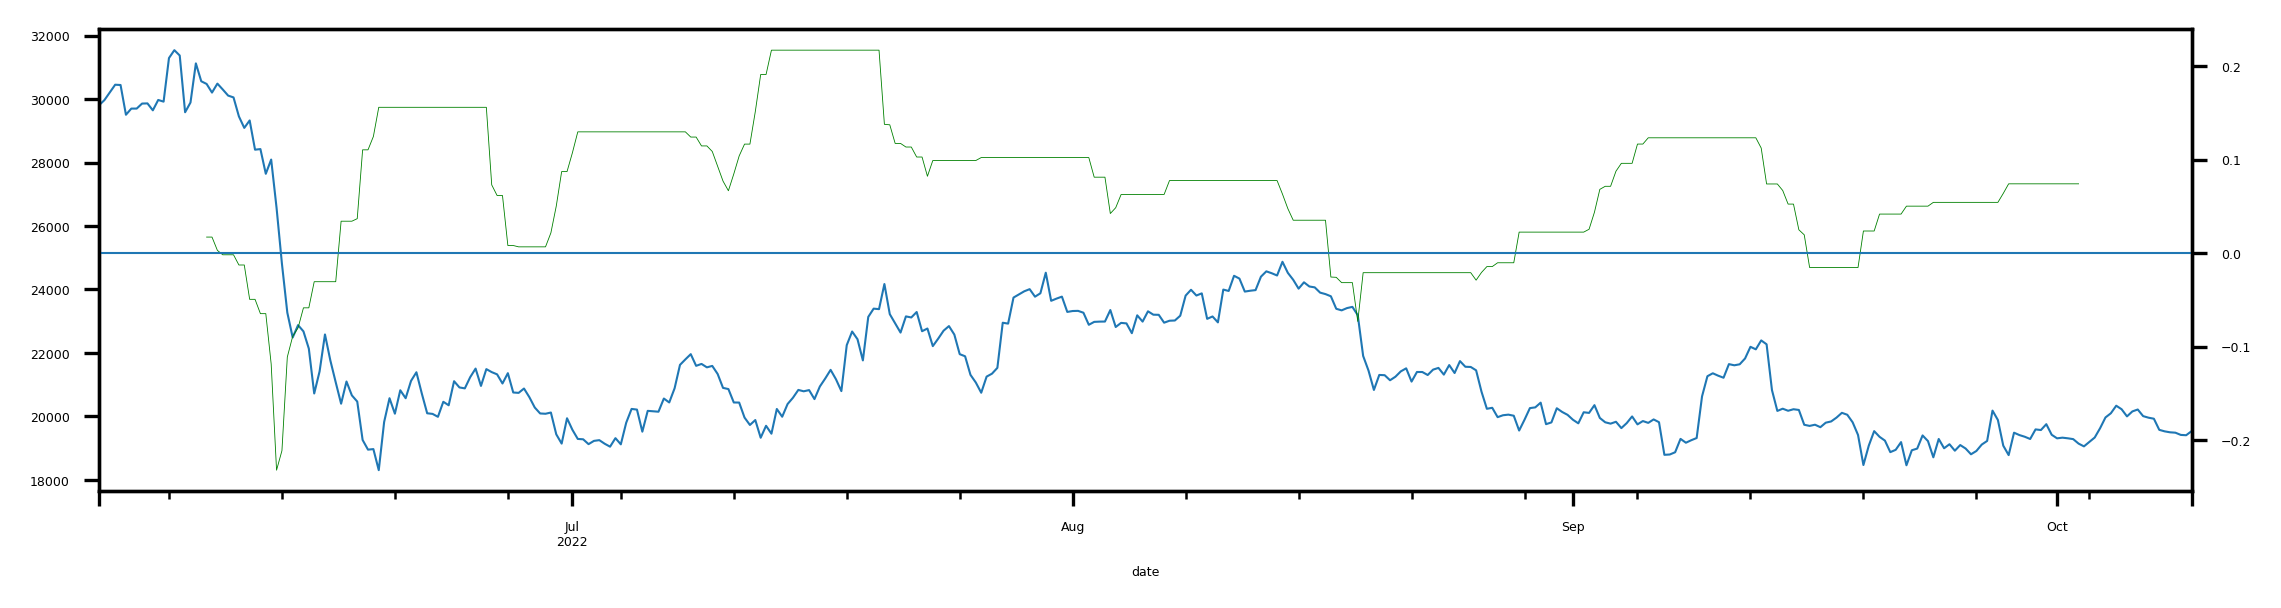

In [84]:
lag = sl_lag.value
wdf['lret'] = (wdf.close/wdf.close.shift()).apply(np.log)
wdf['flret'] = wdf.lret.rolling(window=lag).sum().rolling(lag).max().shift(-lag)

# fig, ax = plt.subplots(figsize=(9,2))
# ax2 = ax.secondary_yaxis(location='right')
wdf.close.plot(figsize=(9,2))
ax2 = wdf.flret.plot(secondary_y=True, c='g', lw=0.2)
ax2.axhline(0)


In [79]:
ax2.axhline(0)

## Find Recent Levels

In [23]:
%load_ext iminizinc

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets
from ipywidgets import *
from IPython.display import display
import IPython
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

from datetime import datetime
# import talib
import pandas_ta as ta
# from talib.abstract import *
from math import *
from collections import OrderedDict
# import vectorbt as vbt    
import json
from decimal import *
getcontext().prec = 6
# import seaborn as sns

import mplfinance as mpf

mpl.rcParams.update({'font.size': 5, 'lines.linewidth': 0.5, 'figure.dpi': 600})
plt.rcParams['lines.linewidth'] = 0.5 


The iminizinc extension is already loaded. To reload it, use:
  %reload_ext iminizinc


In [5]:
odf = pd.read_json(r'../freq-user-data/data/binance/BTC_USDT-1d.json').dropna()
odf.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']

odf['date'] = pd.to_datetime(odf['timestamp'], unit='ms', utc=False)
# df.index = df['time']
# df.set_index('time', drop=True, inplace=True)
odf['idate'] = odf.date.dt.strftime('%Y%m%d')
odf.set_index(pd.DatetimeIndex(odf["date"]), inplace=True, drop=True)
# df = df[['time', 'symbol', 'source', 'resolution', 'open', 'high', 'low', 'close', 'volume']]
# df.to_csv (r'./data/binance/BTC_USDT-5m.csv', index = None)
# df.set_index('time')
odf = odf.sort_index()
odf.head(3)

,timestamp,open,high,low,close,volume,date,idate
date,,,,,,,,
2021-01-01,1609459200000,28923.63,29600.00,28624.57,29331.69,54182.925011,2021-01-01,20210101
2021-01-02,1609545600000,29331.70,33300.00,28946.53,32178.33,129993.873362,2021-01-02,20210102
2021-01-03,1609632000000,32176.45,34778.11,31962.99,33000.05,120957.566750,2021-01-03,20210103


In [18]:
### Rolling peaks

# from minizinc import Instance, Model, Solver, Status

# import nest_asyncio
# nest_asyncio.apply()
# plt.ioff()
# %matplotlib inline

strategy = 'levels'
strategy_params_json = f'./strategy-params/{strategy}.json'

mpl.rcParams.update({'font.size': 3, 'lines.linewidth': 0.5, 'figure.dpi': 300})
dlen = len(odf)

sl_range = IntRangeSlider(value=[int(dlen-1000), dlen],min=0,max=dlen,step=10,description='Rng')
# sl_lag = IntSlider(value=30,min=1,max=100,step=1,description='Lag')
# sl_hold = IntSlider(value=30,min=1,max=100,step=1,description='Hold')
# sl_peaks = IntRangeSlider(value=[-5, 0],min=-10,max=10,step=1,description='Peaks')

strategy_params = {
    # "lag": {'wdg': sl_lag},
    # "hold": {'wdg': sl_hold},
    # "peaks": {'wdg': sl_peaks}
}
strategy_params = {"wrange": {'wdg': sl_range}, **strategy_params}
wdgts = [pv['wdg'] for pk, pv in strategy_params.items()]

ui = widgets.VBox([widgets.HBox(wdgts[i:i+4]) for i in range(0, len(wdgts), 4)])

wdf = None
result = None

def printer(wrange):
    global wdf
    global result
    with open(strategy_params_json, "w") as f: f.write(json.dumps({k: v['wdg'].value for k, v in strategy_params.items()}))
    
    wstart, wend = wrange
    wdf = odf.iloc[wstart:wend, :].copy()

    print(f'N={len(wdf)}, Period: {wdf.index[-1] - wdf.index[0]}, Start: {wdf.index[0]}, End: {wdf.index[-1]}\n')

    stra_params = {}

    # fig = mpf.figure(figsize=(17,8))
    # # ax1 = fig.add_subplot(2,1,1)
    # mpf.plot(wdf,type='candle')

out = widgets.interactive_output(printer, {k : v['wdg'] for k,v in strategy_params.items()});
x = display(ui, out);


if os.path.exists(strategy_params_json):
    with open(strategy_params_json) as f: 
        js = json.loads(f.read());
        for k, v in strategy_params.items(): 
            if k in js: v['wdg'].value=js[k];




Output()

In [78]:
wdf

,timestamp,open,high,low,close,volume,date,idate
date,,,,,,,,
2022-08-04,1659571200000,22816.91,23223.32,22400.00,22622.98,154854.67016,2022-08-04,20220804
2022-08-05,1659657600000,22622.41,23472.86,22586.95,23312.42,175251.69749,2022-08-05,20220805
2022-08-06,1659744000000,23313.56,23354.36,22909.52,22954.21,83911.80307,2022-08-06,20220806
2022-08-07,1659830400000,22954.21,23402.00,22844.62,23174.39,88890.00877,2022-08-07,20220807
2022-08-08,1659916800000,23174.39,24245.00,23154.25,23810.00,170958.44152,2022-08-08,20220808
...,...,...,...,...,...,...,...,...
2023-05-07,1683417600000,28848.19,29138.29,28395.23,28430.10,30003.41028,2023-05-07,20230507
2023-05-08,1683504000000,28430.09,28631.01,27262.00,27668.79,68244.36179,2023-05-08,20230508
2023-05-09,1683590400000,27668.80,27818.00,27353.00,27628.27,40113.31069,2023-05-09,20230509


In [46]:
serc = wdf.close.astype(int).tolist()
sermax = int(wdf.close.max())
# sermax

In [164]:
%%minizinc -m bind

% find troughs between peaks

array[int] of int: mser;
int: sern = length(mser);
set of int: SERN = 1..sern;

array[int] of int: mpeaks;
int: pk_max;
set of int: PK_MAX = 0..pk_max;
int: pkn = length(mpeaks);
set of int: PKN = 1..pkn;

array[1..pkn-1] of var PK_MAX: mtroughs; 
constraint forall(i in 1..pkn-1)(
    mtroughs[i] > mpeaks[i] /\ mtroughs[i] < mpeaks[i+1] 
    /\ forall(j in mpeaks[i]+1..mpeaks[i+1]-1)(mser[j] >= mser[mtroughs[i]])
);


%output [show(sern)];


solve satisfy;

In [175]:
def runmodel(modelname, model_params):
    with open(f'{modelname}-dzn.json', 'w+') as f: f.write(json.dumps(model_params, indent=4))
    mzmodel = Model(f"./{modelname}.mzn")
    gecode = Solver.lookup("gecode")
    instance = Instance(gecode, mzmodel)

    for k,v in model_params.items(): instance[k] = v
    result = instance.solve()
    return result;

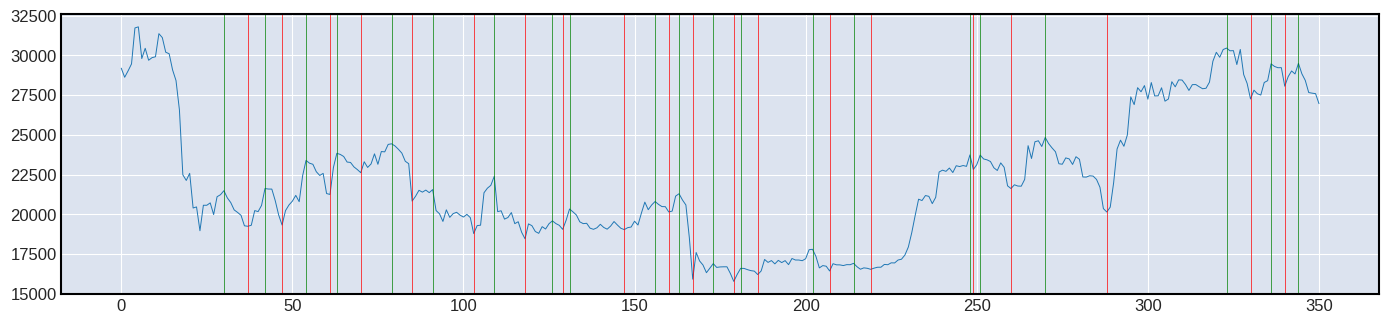

In [177]:
from scipy.signal import *
from minizinc import Instance, Model, Solver, Status

import nest_asyncio
nest_asyncio.apply()

x = wdf.close.to_list()
peaks, pk_props = find_peaks(x, width=3)
pk_widths = peak_widths(x, peaks, rel_height=1)

mser = wdf.close.astype(int).tolist()
mpeaks = peaks.tolist()
pk_max = int(wdf.iloc[peaks].close.max())

model_params = {'mser': mser, 'mpeaks': mpeaks, 'pk_max': pk_max}
mresult = runmodel('troughs-from-peaks', model_params)
mtroughs = mresult['mtroughs']


fig = mpf.figure(figsize=(17,8))
ax1 = fig.add_subplot(2,1,1)

troughs = np.array(mtroughs) - 1

ax1.plot(x, lw=0.7)
for p in peaks:
    ax1.axvline(p, lw=0.5, c='g')
for p in troughs:
    ax1.axvline(p, lw=0.5, c='r')

# plt.hlines(*pk_widths[1:], color="C3", lw=0.4)

In [139]:
mtroughs = sorted(pk_widths[2].astype(int).tolist() + pk_widths[3].astype(int).tolist())
len(peaks), len(mtroughs)

(21, 42)

## Levels

- Quaterly
- Monthly
- 2-Weekly
- Weekly
- 3 - day
- Daily

- OHLC
- Supply / Demand zones - last unbroken for given inow


In [184]:
# Load candles
odf = pd.read_json(r'../freq-user-data/data/binance/BTC_USDT-1d.json').dropna()
odf.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']

odf['date'] = pd.to_datetime(odf['timestamp'], unit='ms', utc=False)
# odf['idate'] = odf.date.dt.strftime('%Y%m%d')
odf.set_index(pd.DatetimeIndex(odf["date"]), inplace=True, drop=True)
# odf = odf.sort_index()
odf = odf[['open', 'high', 'low', 'close']]
odf.head(3)

,open,high,low,close
date,,,,
2021-01-01,28923.63,29600.00,28624.57,29331.69
2021-01-02,29331.70,33300.00,28946.53,32178.33
2021-01-03,32176.45,34778.11,31962.99,33000.05


In [220]:
# Resample and get quoterly
cohlc = ['open','high', 'low', 'close']
fcohlc = [(c,c) for c in cohlc]
ydf = odf.resample('Y', label='left', closed='right').ohlc()[fcohlc].droplevel(axis=1, level=1)
ydf.set_index(ydf.index + pd.DateOffset(1), inplace=True)
qdf = odf.resample('Q', label='left', closed='right').ohlc()[fcohlc].droplevel(axis=1, level=1)
qdf.set_index(qdf.index + pd.DateOffset(1), inplace=True)
mdf = odf.resample('M', label='left', closed='right').ohlc()[fcohlc].droplevel(axis=1, level=1)
mdf.set_index(mdf.index + pd.DateOffset(1), inplace=True)
w2df = odf.resample('2W', label='left', closed='right').ohlc()[fcohlc].droplevel(axis=1, level=1)
w2df.set_index(w2df.index + pd.DateOffset(1), inplace=True)
wdf = odf.resample('W', label='left', closed='right').ohlc()[fcohlc].droplevel(axis=1, level=1)
wdf.set_index(wdf.index + pd.DateOffset(1), inplace=True)
d3df = odf.resample('3D', label='left', closed='right').ohlc()[fcohlc].droplevel(axis=1, level=1)
d3df.set_index(d3df.index + pd.DateOffset(1), inplace=True)
ydf


,open,high,low,close
date,,,,
2021-01-01,28923.63,69000.00,28130.00,46216.93
2022-01-01,46216.93,48189.84,15476.00,16542.40
2023-01-01,16541.77,31000.00,16499.01,26968.62


### Daily pivot levels

# What are Pivot Points?
Pivot points are price levels often used in intraday trading (but they can be used even in swing trading). They are considered “natural” supports and resistances for the price during a daily market session, so they can be quite useful for day traders because the market often behaves in a non-trivial way when it gets closer to them.

There are several types of pivot points, but the classic pivot points are usually defined starting from the last day’s high, low, and close price. Applying some mathematical calculations to these prices on the previous market day, a trader can calculate the pivot levels for the current market day and use them. In this article, I’ll focus on classical pivot points.

A day trader could look for trading opportunities where the price is near a pivot level, waiting for a pullback or a breakout and using the nearest pivot level as a target, for example.

# How to calculate them

- PP = (High + Low + Close) / 3
- R1 = 2 * PP — Low
- S1 = 2 * PP — High
- R2 = PP + (High — Low)
- S2 = PP — (High — Low)
- R3 = PP + 2 * (High — Low)
- S3 = PP — 2 * (High — Low)

# Ideas

- Up or Down fib channels, levels, breaking, rejecting
- Swing low/high fib levels
- 3 recent highs and rejection
- rectangular areas / ranges
- Optimize a strategy for 2/1 risk 2 reward
- Large wicks through support
- Weekly/Monthly/Quarterly support/resistence


## Fish for Risk2Reward

In [3]:
# Load candles
odf = pd.read_json(r'../freq-user-data/data/binance/BTC_USDT-1d.json').dropna()
odf.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']

odf['date'] = pd.to_datetime(odf['timestamp'], unit='ms', utc=False)
# odf['idate'] = odf.date.dt.strftime('%Y%m%d')
odf.set_index(pd.DatetimeIndex(odf["date"]), inplace=True, drop=True)
# odf = odf.sort_index()
odf = odf[['open', 'high', 'low', 'close']]
odf.head(3)

,open,high,low,close
date,,,,
2021-01-01,28923.63,29600.00,28624.57,29331.69
2021-01-02,29331.70,33300.00,28946.53,32178.33
2021-01-03,32176.45,34778.11,31962.99,33000.05


In [5]:
wdf = odf.iloc[:100]#.set_axis(labels=map(str.capitalize, wdf.columns), axis=1,copy=True)
# wdf.set_axis(labels=map(str.capitalize, wdf.columns), axis=1,copy=True)
wdf
# candles

,open,high,low,close
date,,,,
2021-01-01,28923.63,29600.00,28624.57,29331.69
2021-01-02,29331.70,33300.00,28946.53,32178.33
2021-01-03,32176.45,34778.11,31962.99,33000.05
2021-01-04,33000.05,33600.00,28130.00,31988.71
2021-01-05,31989.75,34360.00,29900.00,33949.53
...,...,...,...,...
2021-04-06,59129.99,59495.24,57413.02,57991.15
2021-04-07,57990.03,58655.00,55473.00,55953.45
2021-04-08,55953.44,58153.31,55700.00,58077.52


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
  
plt.figure()


up, down = wdf[wdf.close >= wdf.open], wdf[wdf.close < wdf.open]
col1,col2 = 'green','red'
width, width2 = .3, .07
# Plotting up prices of the stock
plt.bar(up.index, up.close-up.open, width, bottom=up.open, color=col1)
plt.bar(up.index, up.high-up.close, width2, bottom=up.close, color=col1)
plt.bar(up.index, up.low-up.open, width2, bottom=up.open, color=col1)
# Plotting down prices of the stock
plt.bar(down.index, down.close-down.open, width, bottom=down.open, color=col2)
plt.bar(down.index, down.high-down.open, width2, bottom=down.open, color=col2)
plt.bar(down.index, down.low-down.close, width2, bottom=down.close, color=col2)
  
plt.xticks(rotation=30, ha='right')
plt.show()

In [ ]:
def plot_candles(wdf, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    up, down = wdf[wdf.close >= wdf.open], wdf[wdf.close < wdf.open]
    col1,col2 = 'green','red'
    width, width2 = .3, .07
    # Plotting up prices of the stock
    ax.bar(up.index, up.close-up.open, width, bottom=up.open, color=col1)
    ax.bar(up.index, up.high-up.close, width2, bottom=up.close, color=col1)
    ax.bar(up.index, up.low-up.open, width2, bottom=up.open, color=col1)
    # Plotting down prices of the stock
    ax.bar(down.index, down.close-down.open, width, bottom=down.open, color=col2)
    ax.bar(down.index, down.high-down.open, width2, bottom=down.open, color=col2)
    ax.bar(down.index, down.low-down.close, width2, bottom=down.close, color=col2)    
    plt.xticks(rotation=30, ha='right')

plot_candles(wdf)

In [41]:
# windowed
wnd = 300
jmp = 50
hold_periods=[3, 7, 14]
# def analyze_trades(odf, entries=[], hold_periods=[]):
odf_split = [ (i,odf.iloc[i:i+wnd]) for i in [s * jmp for s in range((odf.shape[0] - wnd) // jmp + 1)] ]   
adf = pd.DataFrame.from_dict(
{
    **{
        (f'Ho_{ho}', 'L', i) : wdf.close.divide(wdf.low.rolling(ho).min().shift(-ho)).apply(np.log).describe() 
            for (i,wdf) in odf_split
            for ho in hold_periods
    },
    **{
        (f'Ho_{ho}', 'H', i) : wdf.close.divide(wdf.high.rolling(ho).max().shift(-ho)).apply(np.log).describe() 
            for (i,wdf) in odf_split
            for ho in hold_periods
    }
}
).unstack().unstack(level=0).unstack(level=0).unstack(level=-1)

# for ho in hold_periods: wdf[(r2r)
#     # return adf
# idx=pd.IndexSlice
adf.loc[idx[:], idx[:,['H', 'L'],'50%']].head(3)
# adf
# adf = analyze_trades(odf, entries)

Ho_14                Ho_3                Ho_7          
            H         L         H         L         H         L
          50%       50%       50%       50%       50%       50%
0   -0.102395  0.110923 -0.050251  0.047475 -0.075591  0.068149
50  -0.085955  0.113564 -0.041435  0.046313 -0.057939  0.069059
100 -0.069962  0.124734 -0.036630  0.046768 -0.053619  0.070723

In [37]:
### R2R fishing
from matplotlib import pyplot as plt

strategy = 'r2r-fishing'
strategy_params_json = f'./strategy-params/{strategy}.json'

mpl.rcParams.update({'font.size': 3, 'lines.linewidth': 0.5, 'figure.dpi': 300})
dlen = len(odf)

sl_range = IntRangeSlider(value=[int(dlen-1000), dlen],min=0,max=dlen,step=10,description='Rng',continuous_update=False)
# sl_lag = IntSlider(value=30,min=1,max=100,step=1,description='Lag')
sl_hold = IntSlider(value=30,min=1,max=50,step=1,description='Hold',continuous_update=False)
sl_r2r = FloatSlider(value=0.5,min=0,max=2,step=0.1,description='R2R',continuous_update=False)
sl_pq = FloatSlider(value=0.5,min=0,max=1,step=0.05,description='PQ',continuous_update=False)
sl_rq = FloatSlider(value=0.5,min=0,max=1,step=0.05,description='RQ',continuous_update=False)
# sl_peaks = IntRangeSlider(value=[-5, 0],min=-10,max=10,step=1,description='Peaks')
sl_rwnd = IntSlider(value=100,min=10,max=dlen,step=int(dlen / 20),description='RWnd')

strategy_params = {
    "hold": {'wdg': sl_hold},
    "r2r": {'wdg': sl_r2r},
    "rwnd": {'wdg': sl_rwnd},
    "pq": {'wdg': sl_pq},
    "rq": {'wdg': sl_rq},
}
strategy_params = {
    "wrange": {'wdg': sl_range}, **strategy_params
}
wdgts = [pv['wdg'] for pk, pv in strategy_params.items()]

ui = widgets.VBox([widgets.HBox(wdgts[i:i+4]) for i in range(0, len(wdgts), 4)])

if os.path.exists(strategy_params_json):
    with open(strategy_params_json) as f: 
        js = json.loads(f.read());
        for k, v in strategy_params.items(): 
            if k in js: v['wdg'].value=js[k];

else: print(f'File not found: {strategy_params_json}')

wdf = None
result = None

def printer(
        wrange, hold, r2r, rwnd, pq, rq
):
    global wdf
    global result
    with open(strategy_params_json, "w") as f: f.write(json.dumps({k: v['wdg'].value for k, v in strategy_params.items()}))
    
    wstart, wend = wrange
    wdf = odf.iloc[wstart:wend, :].copy()

    print(f'N={len(wdf)}, Period: {wdf.index[-1] - wdf.index[0]}, Start: {wdf.index[0]}, End: {wdf.index[-1]}\n')

    # stra_params = {}
    ho = hold
    wdf['rfd'] = wdf.low.rolling(ho).min().shift(-ho)
    wdf['rfu'] = wdf.high.rolling(ho).max().shift(-ho)
    wdf['prfu'] = np.log(wdf.rfu / wdf.close)
    wdf['prfd'] = np.log(wdf.rfd / wdf.close)
    wdf['pr2r'] = wdf.prfu / - wdf.prfd

    fig = plt.figure(figsize=(9,3))

    (ax1,ax2, ax3) = fig.subplots(3, 1, height_ratios=[3,1,1]);
    # ax2.
    plot_candles(wdf, ax=ax1)
    wdf.rfu.plot(ax=ax1, lw=0.04, c='g')
    wdf.rfd.plot(ax=ax1, lw=0.04, c='r')
    wdf.prfu.plot(ax=ax2, lw=0.2, c='g')
    wdf.prfd.plot(ax=ax2, lw=0.2, c='r')
    # ax1.axhline(0, secon)
    # ax12 = ax1.twiny()
    # ax12.axhline(0)
    wdf.pr2r.clip(-5,5).plot(ax=ax1, lw=0.05, c='b')
    # wdf.r2r.plot(ax=ax1,secondary_y=True, lw=0.2, c='gray')
    # ax2.axhline(2, lw=0.4)

    # ax1 = fig.add_subplot(2,1,1)
    # ax2 = fig.add_subplot(2,1,2, sharex=ax1)

    # fig = plt.figure(title="---")

    # fig.layout.width="1200px"


    # mpf.plot(wdf, ax=ax1,  type='candle', warn_too_much_data=10000)
    # ax2.plot(wdf.r2r.clip(-5,5), lw=0.5)
    # fig = mpf.figure(figsize=(17,8))
    # # ax1 = fig.add_subplot(2,1,1)
    # mpf.plot(wdf,type='candle')
    # plt.show()

out = widgets.interactive_output(printer, {k : v['wdg'] for k,v in strategy_params.items()});
x = display(ui, out);





Output()

In [ ]:
wdf.pr2r.clip(-5,5).plot(logy=True)
